In [ ]:
# === Cell 1: Import & Load Data ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay
)
import joblib, json, os
from pathlib import Path

# === Load Dataset ===
# Pastikan file PhiUSIIL_Phishing_URL_Dataset.csv sudah diupload ke Colab
df = pd.read_csv('/content/drive/MyDrive/PhiUSIIL/PhiUSIIL_Phishing_URL_Dataset.csv')

print("Ukuran data:", df.shape)
df.head()

Ukuran data: (235795, 56)


,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  int64  
 13  

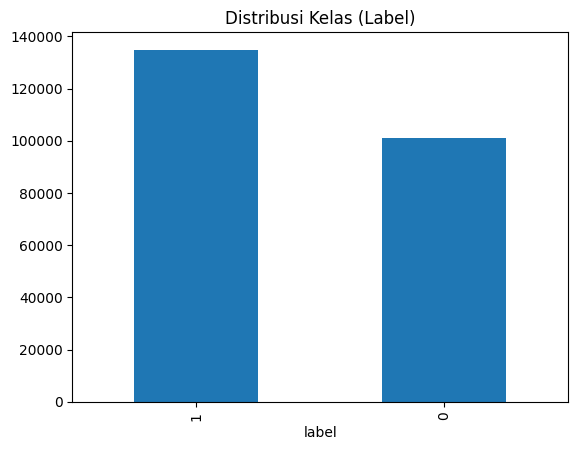

In [ ]:
# === Cell 2: EDA ===
print("Info dataset:")
df.info()

print("\nCek missing values:")
print(df.isna().sum().sort_values(ascending=False).head(10))

print("\nNilai unik per kolom:")
print(df.nunique().sort_values(ascending=False).head(15))

# Cari kolom target
for col in df.columns:
    if 'label' in col.lower() or 'class' in col.lower():
        print(f"Kolom target ditemukan: {col}")
        target_col = col
        break

# Distribusi kelas
df[target_col].value_counts().plot(kind='bar', title='Distribusi Kelas (Label)')
plt.show()


In [ ]:
# === Cell 3: Split fitur dan label ===
X = df.drop(columns=[target_col])
y = df[target_col]

# Drop kolom URL atau teks panjang
drop_cols = [c for c in X.columns if c.lower() in ['url', 'uri', 'domain', 'hostname', 'path']]
X = X.drop(columns=drop_cols, errors='ignore')

# Identifikasi tipe fitur
num_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_features = [c for c in X.columns if c not in num_features]

print("Fitur numerik:", len(num_features))
print("Fitur kategorikal:", len(cat_features))


Fitur numerik: 50
Fitur kategorikal: 3


In [ ]:
# === Cell 4: Split dan pipeline ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing
num_tf = Pipeline([('scaler', StandardScaler())])
cat_tf = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocess = ColumnTransformer([
    ('num', num_tf, num_features),
    ('cat', cat_tf, cat_features)
])

# Model
lr = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')

# Pipeline
pipe = Pipeline([
    ('preprocess', preprocess),
    ('model', lr)
])

pipe.fit(X_train, y_train)
print("Model logistic regression selesai dilatih.")


Model logistic regression selesai dilatih.


In [ ]:
# === Cell 5: Evaluasi ===
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print(f"""
Akurasi   : {acc:.5f}
Presisi   : {prec:.5f}
Recall    : {rec:.5f}
F1-score  : {f1:.5f}
ROC-AUC   : {roc:.5f}
""")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)



Akurasi   : 0.99992
Presisi   : 0.99985
Recall    : 1.00000
F1-score  : 0.99993
ROC-AUC   : 1.00000


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20189
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159


Confusion Matrix:
 [[20185     4]
 [    0 26970]]


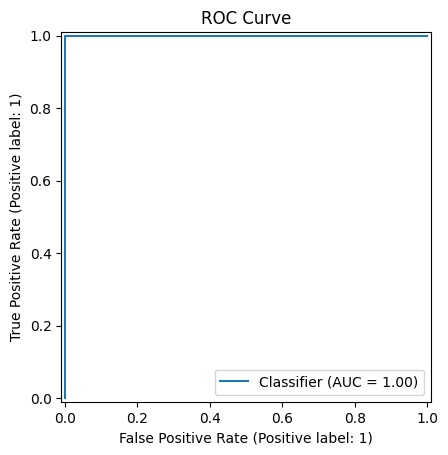

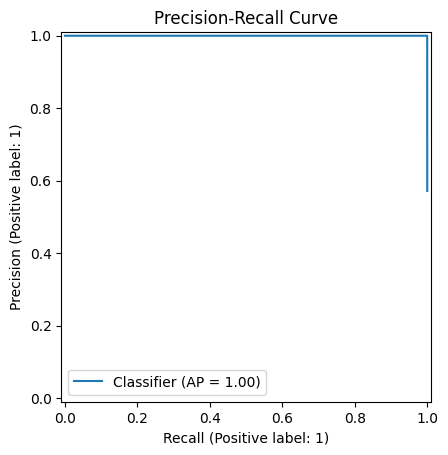

In [ ]:
# === Cell 6: Visualisasi ===
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title("Precision-Recall Curve")
plt.show()


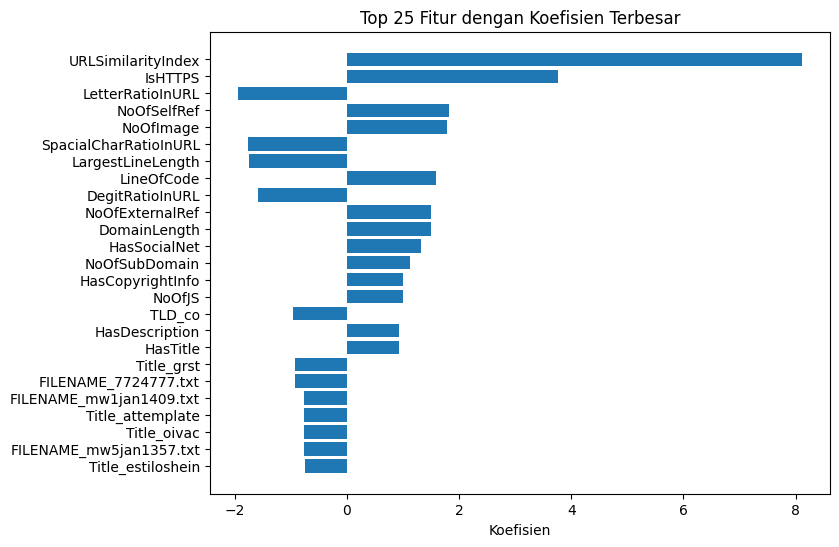

In [ ]:
# === Cell 7: Koefisien fitur ===
def get_feature_names(ct):
    names = []
    for name, trans, cols in ct.transformers_:
        if hasattr(trans, 'get_feature_names_out'):
            fn = trans.get_feature_names_out(cols)
        else:
            fn = cols
        names.extend(fn)
    return names

feature_names = get_feature_names(pipe.named_steps['preprocess'])
coefs = pipe.named_steps['model'].coef_.ravel()

coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
coef_df['abs_coef'] = coef_df['coef'].abs()
top_coef = coef_df.sort_values('abs_coef', ascending=False).head(25)

plt.figure(figsize=(8,6))
plt.barh(top_coef['feature'][::-1], top_coef['coef'][::-1])
plt.title("Top 25 Fitur dengan Koefisien Terbesar")
plt.xlabel("Koefisien")
plt.show()


In [ ]:
# === Cell 8: Simpan model sklearn ===
os.makedirs('/content/drive/MyDrive/PhiUSIIL/model', exist_ok=True)
joblib.dump(pipe, '/content/drive/MyDrive/PhiUSIIL/model/phishing_lr_pipeline.pkl')

meta = {
    "features_num": num_features,
    "features_cat": cat_features,
    "target": target_col,
    "metrics": {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": roc}
}
with open('/content/drive/MyDrive/PhiUSIIL/model/metadata.json', 'w') as f:
    json.dump(meta, f, indent=2)

print("Model dan metadata tersimpan di /content/model/")


Model dan metadata tersimpan di /content/model/


In [ ]:
# === Cell 9: Export ke TFLite (numerik saja) ===
import tensorflow as tf

# Gunakan hanya fitur numerik agar mudah diexport
scaler = StandardScaler()
Xn_train = scaler.fit_transform(X_train[num_features])
Xn_test = scaler.transform(X_test[num_features])

# Bangun model TF sederhana
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(Xn_train.shape[1],)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xn_train, y_train, epochs=40, batch_size=256, verbose=1)

# Simpan TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('/content/drive/MyDrive/PhiUSIIL/model/phishing_model_numeric.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model TFLite berhasil disimpan di /content/drive/MyDrive/PhiUSIIL/model/model/phishing_model_numeric.tflite")

# Simpan statistik scaler untuk preprocessing di client
scaler_data = {"mean": scaler.mean_.tolist(), "scale": scaler.scale_.tolist(), "features": num_features}
with open('/content/drive/MyDrive/PhiUSIIL/model/scaler_stats.json', 'w') as f:
    json.dump(scaler_data, f, indent=2)


Epoch 1/40
737/737 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9733 - loss: 0.1461
Epoch 2/40
737/737 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9967 - loss: 0.0289
Epoch 3/40
737/737 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9984 - loss: 0.0159
Epoch 4/40
737/737 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9989 - loss: 0.0104
Epoch 5/40
737/737 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9992 - loss: 0.0075
Epoch 6/40
737/737 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9993 - loss: 0.0057
Epoch 7/40
737/737 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9994 - loss: 0.0046
Epoch 8/40
737/737 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9994 - loss: 0.0036
Epoch 9/40
737/737 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9997 - loss: 0.0029
Epoch 10/40
737/737 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9996 - loss: 0.0025
Epoch 11/40
737/737 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9996 - loss: 0.0020
Epoch 12/40
737/737 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

In [ ]:
# === Cell 10: Uji inference ===
# Ambil satu sampel acak
sample = X_test.sample(2, random_state=0)
proba = pipe.predict_proba(sample)[0,1]
label = "Phishing" if proba >= 0.5 else "Legit"

print("Prediksi:", label)
print("Probabilitas:", proba)


Prediksi: Legit
Probabilitas: 4.2160918082729086e-11


In [ ]:
# Cek performa di data test (yang tidak digunakan di training)
test_loss, test_acc = model.evaluate(Xn_test, y_test, verbose=0)
print(f"Akurasi Test Set: {test_acc:.4f}, Loss: {test_loss:.6f}")


Akurasi Test Set: 0.9999, Loss: 0.000293


In [ ]:
# Hapus baris duplikat (berdasar seluruh kolom fitur + label)
df_dedup = df.drop_duplicates()
print("Sebelum:", df.shape, "Sesudah dedup:", df_dedup.shape)

# Ulangi pemisahan dan pelatihan cepat (pakai pipeline yang sama seperti sebelumnya)
from sklearn.model_selection import train_test_split

X_all = df_dedup.drop(columns=[target_col])
y_all = df_dedup[target_col]

# Buang kolom URL/teks panjang lagi jika ada
drop_cols = [c for c in X_all.columns if c.lower() in ['url','uri','domain','hostname','path']]
X_all = X_all.drop(columns=drop_cols, errors='ignore')

num_features = [c for c in X_all.columns if pd.api.types.is_numeric_dtype(X_all[c])]
cat_features = [c for c in X_all.columns if c not in num_features]

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_all, y_all, test_size=0.2, random_state=123, stratify=y_all
)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

preprocess2 = ColumnTransformer([
    ('num', Pipeline([('scaler', StandardScaler())]), num_features),
    ('cat', Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_features),
])
pipe2 = Pipeline([('preprocess', preprocess2),
                  ('model', LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear'))])

pipe2.fit(X_train2, y_train2)
y_pred2 = pipe2.predict(X_test2)
y_proba2 = pipe2.predict_proba(X_test2)[:,1]

print({
    "acc": accuracy_score(y_test2, y_pred2),
    "prec": precision_score(y_test2, y_pred2),
    "rec": recall_score(y_test2, y_pred2),
    "f1": f1_score(y_test2, y_pred2),
    "roc_auc": roc_auc_score(y_test2, y_proba2)
})


Sebelum: (235795, 56) Sesudah dedup: (235795, 56)
{'acc': 0.9999575902796921, 'prec': 0.9999258490286222, 'rec': 1.0, 'f1': 0.9999629231396685, 'roc_auc': np.float64(0.9999539263121823)}


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, cv=skf, scoring='f1')
print("F1 per fold:", scores, "→ mean:", scores.mean(), "±", scores.std())


F1 per fold: [0.99994439 0.99985171 0.99996292 0.99996292 0.99988877] → mean: 0.9999221429231874 ± 4.448649372541599e-05


In [ ]:
# Jalankan hanya jika dataset-mu punya kolom domain seperti 'domain' / 'host'
if any(c.lower() == 'domain' for c in df.columns):
    dom_col = [c for c in df.columns if c.lower() == 'domain'][0]
    from sklearn.model_selection import GroupKFold
    Xg = df.drop(columns=[target_col])
    yg = df[target_col]
    groups = df[dom_col].astype(str)

    # Buang kolom mentah yang rawan
    Xg = Xg.drop(columns=[col for col in ['url','uri','hostname','path','domain'] if col in Xg.columns], errors='ignore')
    num_g = [c for c in Xg.columns if pd.api.types.is_numeric_dtype(Xg[c])]
    cat_g = [c for c in Xg.columns if c not in num_g]
    prep_g = ColumnTransformer([
        ('num', Pipeline([('scaler', StandardScaler())]), num_g),
        ('cat', Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_g),
    ])
    pipe_g = Pipeline([('preprocess', prep_g),
                      ('model', LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear'))])

    gkf = GroupKFold(n_splits=5)
    f1s = []
    from sklearn.metrics import f1_score
    for train_idx, test_idx in gkf.split(Xg, yg, groups):
        pipe_g.fit(Xg.iloc[train_idx], yg.iloc[train_idx])
        pred = pipe_g.predict(Xg.iloc[test_idx])
        f1s.append(f1_score(yg.iloc[test_idx], pred))
    print("GroupKFold (by domain) F1 mean:", np.mean(f1s), "±", np.std(f1s))

GroupKFold (by domain) F1 mean: 0.9999035924304346 ± 4.3036386380231574e-05


In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve

proba = pipe.predict_proba(X_test)[:,1]
fpr, tpr, thr = roc_curve(y_test, proba)

# pilih ambang dengan FPR <= 0.001 (0.1%)
target_fpr = 0.001
candidates = [(f, t, th) for f, t, th in zip(fpr, tpr, thr) if f <= target_fpr]
best_f, best_t, best_th = max(candidates, key=lambda x: x[1]) if candidates else (fpr[0], tpr[0], thr[0])
print(f"Chosen threshold: {best_th:.4f} (FPR≈{best_f:.5f}, TPR≈{best_t:.5f})")

# Evaluasi dengan threshold ini
pred_custom = (proba >= best_th).astype(int)
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, pred_custom))
print(classification_report(y_test, pred_custom))


Chosen threshold: 0.7775 (FPR≈0.00010, TPR≈1.00000)
[[20187     2]
 [    0 26970]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20189
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159

